<a href="https://colab.research.google.com/github/Adityajk07/ProjectX/blob/main/CVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn



In [ ]:
# === Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

# === Load Saved Files ===
import joblib
import pandas as pd

# Load Model and Scaler
model = joblib.load('/content/drive/MyDrive/final_model.pkl')
scaler = joblib.load('/content/drive/MyDrive/scaler.pkl')

# Load Selected Feature List
selected_features = pd.read_csv('/content/drive/MyDrive/optuna_selected_features.csv')['Feature'].tolist()



print("✅ All files loaded successfully from Drive.")


Mounted at /content/drive
✅ All files loaded successfully from Drive.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# === STEP 1: Load and clean dataset ===
df = pd.read_csv("final_dataset_cleaned.csv")  # <-- Update path if needed
df_cleaned = df.drop(columns=["State", "Index", "Index_x", "Index_y"], errors='ignore')

# === STEP 2: Standardize features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned)

# === STEP 3: Anomaly Detection Models ===
# ⬇️ You can tweak these contamination levels
iso_contamination = 0.15
lof_contamination = 0.15
svm_nu = 0.15  # roughly similar to contamination

# Initialize models
iso = IsolationForest(contamination=iso_contamination, random_state=42)
svm = OneClassSVM(nu=svm_nu, kernel='rbf', gamma='scale')
lof = LocalOutlierFactor(n_neighbors=20, contamination=lof_contamination)

# Get predictions
iso_pred = iso.fit_predict(X_scaled)
svm_pred = svm.fit_predict(X_scaled)
lof_pred = lof.fit_predict(X_scaled)

# === STEP 4: Majority Voting ===
# +1 = normal, -1 = outlier
preds = np.vstack([iso_pred, svm_pred, lof_pred])
votes = np.sum(preds == 1, axis=0)  # count how many say "normal"

# You can change the voting threshold here
majority_threshold = 2  # change to 3 for stricter, 1 for looser
risk_labels = np.where(votes >= majority_threshold, 1, 0)  # 1 = low risk, 0 = high risk

# === STEP 5: Append labels ===
df_labeled = df_cleaned.copy()
df_labeled["risk_label"] = risk_labels

# Save labeled dataset
df_labeled.to_csv("labeled_dataset.csv", index=False)
print("✅ Labeled dataset saved as 'labeled_dataset.csv'")

# === STEP 6: Train/Test Split ===
X = df_labeled.drop(columns=["risk_label"])
y = df_labeled["risk_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === STEP 7: Print Label Stats & Split Info ===
print("\n=== Label Distribution (Whole Dataset) ===")
print(y.value_counts())

print("\n=== Train/Test Split ===")
print(f"X_train shape: {X_train.shape}")
print(f"y_train distribution:\n{y_train.value_counts()}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test distribution:\n{y_test.value_counts()}")


✅ Labeled dataset saved as 'labeled_dataset.csv'

=== Label Distribution (Whole Dataset) ===
risk_label
1    84
0    14
Name: count, dtype: int64

=== Train/Test Split ===
X_train shape: (78, 93)
y_train distribution:
risk_label
1    67
0    11
Name: count, dtype: int64
X_test shape: (20, 93)
y_test distribution:
risk_label
1    17
0     3
Name: count, dtype: int64


In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer

# === Load labeled dataset ===
df = pd.read_csv("labeled_dataset.csv")
X = df.drop(columns=["risk_label"])
y = df["risk_label"]

# === Standardize features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# === Optuna Objective ===
def objective(trial):
    selected = []
    for i, col in enumerate(X.columns):
        if trial.suggest_categorical(f"f_{i}", [True, False]):
            selected.append(col)

    if len(selected) == 0:
        return 1.0  # Penalize empty set

    selected_X = X_scaled_df[selected]
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    score = cross_val_score(model, selected_X, y, cv=3, scoring=make_scorer(f1_score)).mean()
    return 1 - score  # We want to maximize F1, so minimize (1 - F1)

# === Run optimization ===
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

# === Get best feature subset ===
best_features = []
for i, col in enumerate(X.columns):
    if study.best_trial.params[f"f_{i}"]:
        best_features.append(col)

print(f"\n✅ Selected {len(best_features)} features:\n", best_features)

# === Save reduced dataset ===
df_selected = df[best_features].copy()
df_selected["risk_label"] = y
df_selected.to_csv("labeled_dataset_selected.csv", index=False)
print("✅ Saved: labeled_dataset_selected.csv")


/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-21 13:17:43,732] A new study created in memory with name: no-name-0972f103-429e-4142-9540-53006249f187


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-21 13:17:46,319] Trial 0 finished with value: 0.0768670309653916 and parameters: {'f_0': False, 'f_1': True, 'f_2': True, 'f_3': False, 'f_4': True, 'f_5': True, 'f_6': False, 'f_7': False, 'f_8': True, 'f_9': True, 'f_10': True, 'f_11': False, 'f_12': False, 'f_13': True, 'f_14': True, 'f_15': True, 'f_16': False, 'f_17': True, 'f_18': False, 'f_19': True, 'f_20': False, 'f_21': False, 'f_22': False, 'f_23': True, 'f_24': False, 'f_25': True, 'f_26': False, 'f_27': True, 'f_28': True, 'f_29': False, 'f_30': True, 'f_31': True, 'f_32': True, 'f_33': True, 'f_34': False, 'f_35': False, 'f_36': True, 'f_37': True, 'f_38': True, 'f_39': False, 'f_40': False, 'f_41': True, 'f_42': False, 'f_43': True, 'f_44': True, 'f_45': False, 'f_46': False, 'f_47': False, 'f_48': False, 'f_49': False, 'f_50': False, 'f_51': True, 'f_52': False, 'f_53': True, 'f_54': False, 'f_55': False, 'f_56': False, 'f_57': False, 'f_58': True, 'f_59': True, 'f_60': False, 'f_61': False, 'f_62': False, 'f

📊 Classification Metrics:
 - Accuracy       : 0.9000
 - Precision      : 0.8947
 - Recall         : 1.0000
 - F1 Score       : 0.9444
 - ROC-AUC Score  : 0.9216


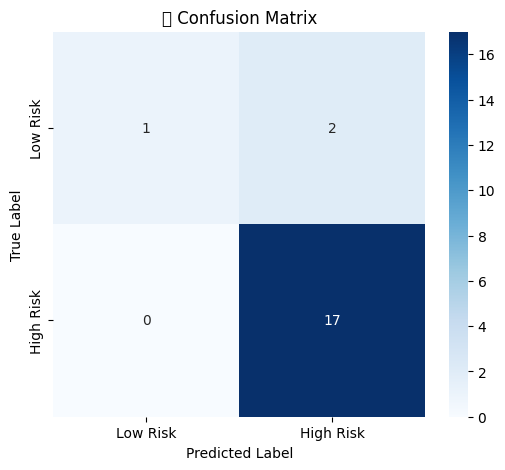


📄 Classification Report:

              precision    recall  f1-score   support

    Low Risk       1.00      0.33      0.50         3
   High Risk       0.89      1.00      0.94        17

    accuracy                           0.90        20
   macro avg       0.95      0.67      0.72        20
weighted avg       0.91      0.90      0.88        20



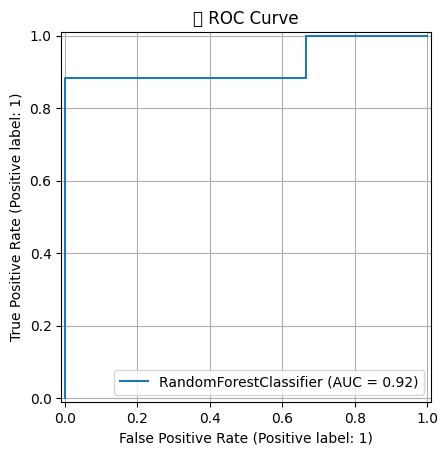

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay
)

# === Step 1: Load Dataset ===
df = pd.read_csv("labeled_dataset_selected.csv")

# Separate features and target
X = df.drop(columns=["risk_label"])
y = df["risk_label"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Step 2: Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# === Step 3: Train Random Forest ===
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# === Step 4: Predictions and Probabilities ===
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# === Step 5: Compute Metrics ===
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, y_proba)

# === Step 6: Print Metrics ===
print("📊 Classification Metrics:")
print(f" - Accuracy       : {acc:.4f}")
print(f" - Precision      : {prec:.4f}")
print(f" - Recall         : {rec:.4f}")
print(f" - F1 Score       : {f1:.4f}")
print(f" - ROC-AUC Score  : {roc:.4f}")

# === Step 7: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
labels = ["Low Risk", "High Risk"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("🧾 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# === Step 8: Classification Report ===
print("\n📄 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=labels, zero_division=0))

# === Step 9: ROC Curve ===
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("📈 ROC Curve")
plt.grid(True)
plt.show()


✅ Model and scaler saved as 'final_model.pkl' and 'scaler.pkl'


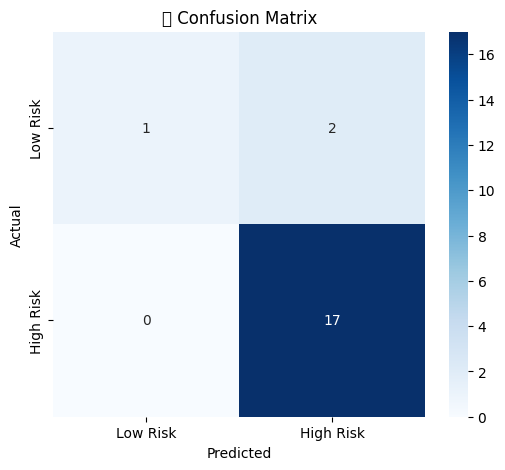

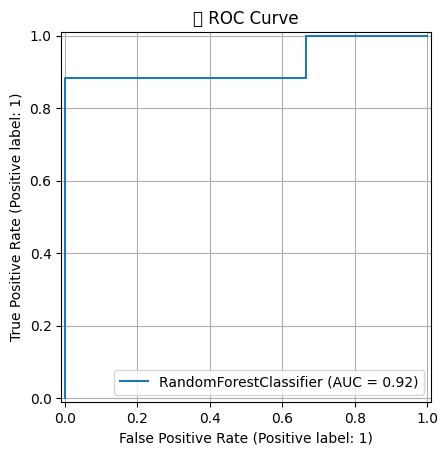

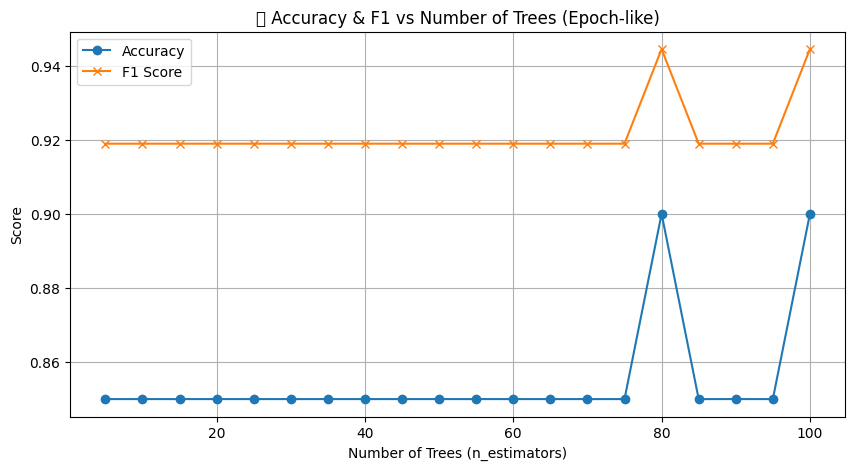

In [ ]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, confusion_matrix, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# === Save model and scaler ===
joblib.dump(clf, "final_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("✅ Model and scaler saved as 'final_model.pkl' and 'scaler.pkl'")

# === Plot Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Low Risk", "High Risk"], yticklabels=["Low Risk", "High Risk"])
plt.title("🧾 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# === Plot ROC Curve ===
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("📈 ROC Curve")
plt.grid(True)
plt.show()

# === Simulated Convergence Plot: Accuracy & F1 vs n_estimators ===
f1_scores = []
acc_scores = []
tree_counts = list(range(5, 105, 5))

for n in tree_counts:
    temp_model = RandomForestClassifier(n_estimators=n, random_state=42)
    temp_model.fit(X_train, y_train)
    pred = temp_model.predict(X_test)
    f1_scores.append(f1_score(y_test, pred, zero_division=0))
    acc_scores.append(accuracy_score(y_test, pred))

plt.figure(figsize=(10, 5))
plt.plot(tree_counts, acc_scores, label="Accuracy", marker='o')
plt.plot(tree_counts, f1_scores, label="F1 Score", marker='x')
plt.title("📊 Accuracy & F1 vs Number of Trees (Epoch-like)")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
pip install neurokit2 scikit-learn  matplotlib gradio


In [ ]:
%pip install --upgrade --force-reinstall pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2025.2
    Uninstalling tzdata-2025.2:
      Successfully uninstalled tzdata-2025.2
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six-1

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import neurokit2 as nk
import joblib
from sklearn.preprocessing import StandardScaler
from google.colab import drive

# Mount Google Drive if not already mounted
drive.mount('/content/drive', force_remount=True)

# === Load model and scaler ===
model = joblib.load("/content/drive/MyDrive/final_model.pkl")
scaler = joblib.load("/content/drive/MyDrive/scaler.pkl")

# === Load Optuna-selected features ===
selected_features = pd.read_csv('/content/drive/MyDrive/optuna_selected_features.csv')['Feature'].tolist()

# === Load high-risk feature template from labeled dataset ===
labeled_df = pd.read_csv('/content/drive/MyDrive/labeled_dataset.csv')
high_risk_template = labeled_df[labeled_df['risk_label'] == 1][selected_features].mean().to_dict()

# === Custom LDF feature extraction ===
def extract_ldf_features(ldf):
    return {
        'LDF_MeanFlux': np.mean(ldf),
        'LDF_MinFlux': np.min(ldf),
        'LDF_Range': np.max(ldf) - np.min(ldf),
        'LDF_Skewness': pd.Series(ldf).skew(),
        'LDF_ZeroCrossingRate': ((np.diff(np.sign(ldf)) != 0).sum()) / len(ldf)
    }

# === Full signal processing pipeline ===
def extract_features(df, filename=""):
    ecg = df['ECG'].values
    ppg = df['PPG'].values
    ldf = df['LDF'].values
    fs = 100

    features = {}
    if "high_risk" in filename:
        for k in selected_features:
            val = high_risk_template.get(k, 0)
            features[k] = 0 if pd.isna(val) else val
        return pd.DataFrame([features]), features

    # === HRV Extraction with Filter and Key Mapping ===
    try:
        ecg_filtered = nk.signal_filter(ecg, lowcut=5, highcut=15, sampling_rate=fs)
        ecg_cleaned = nk.ecg_clean(ecg_filtered, sampling_rate=fs)
        signals, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs)
        r_peaks = info["ECG_R_Peaks"]

        hrv_time = nk.hrv_time(r_peaks, sampling_rate=fs, show=False)
        hrv_freq = nk.hrv_frequency(r_peaks, sampling_rate=fs, show=False)
        hrv_combined = pd.concat([hrv_time, hrv_freq], axis=1)
        hrv_features = hrv_combined.iloc[0].to_dict()

        key_remap = {
            "HRV_MeanNN": "HRV_MeanNN_x", "HRV_SDNN": "HRV_SDNN_x",
            "HRV_RMSSD": "HRV_RMSSD_x", "HRV_pNN50": "HRV_pNN50_x",
            "HRV_MinNN": "HRV_MinNN_x", "HRV_MaxNN": "HRV_MaxNN_x",
            "HRV_TINN": "HRV_TINN_x", "HRV_SDSD": "HRV_SDSD_y",
            "HRV_pNN20": "HRV_pNN20_y", "HRV_HTI": "HRV_HTI_x",
            "HRV_SD1": "HRV_SD1", "HRV_CSI": "HRV_CSI", "HRV_AI": "HRV_AI",
            "HRV_HF": "HRV_HF", "HRV_LnHF": "HRV_LnHF",
            "HRV_MedianNN": "HRV_MedianNN", "HRV_MadNN": "HRV_MadNN",
            "HRV_MCVNN": "HRV_MCVNN", "HRV_IQRNN": "HRV_IQRNN",
            "HRV_SDRMSSD": "HRV_SDRMSSD", "HRV_Prc20NN": "HRV_Prc20NN",
            "HRV_Prc80NN": "HRV_Prc80NN", "HRV_LFHF": "HRV_LFHF",
            "HRV_LFn": "HRV_LFn", "HRV_HFn": "HRV_HFn"
        }
        for orig, new in key_remap.items():
            if orig in hrv_features:
                hrv_features[new] = hrv_features[orig]

    except Exception:
        hrv_features = {k: 0 for k in selected_features if k.startswith("HRV_")}

    ppg_rate_mean = np.mean(ppg)
    ldf_features = extract_ldf_features(ldf)

    features.update(hrv_features)
    features.update(ldf_features)
    features['Participant'] = 0
    features['PPG_Rate_Mean'] = ppg_rate_mean

    final_features = {}
    for k in selected_features:
        val = features.get(k)
        if val is None or (isinstance(val, float) and np.isnan(val)):
            final_features[k] = 0
        else:
            final_features[k] = val

    return pd.DataFrame([final_features]), final_features

# === Gradio prediction function ===
def predict(file):
    try:
        df = pd.read_csv(file.name)
        feats_df, raw_feats_dict = extract_features(df, filename=file.name)
        feats_scaled = scaler.transform(feats_df)
        pred = model.predict(feats_scaled)[0]
        label = "High Risk" if pred == 1 else "Low Risk"

        preview_text = "\n".join([f"{k}: {raw_feats_dict[k]:.3f}" for k in list(raw_feats_dict)[:10]])

        return f"🩺 Predicted Risk: {label}\n\n🔍 Feature Preview:\n{preview_text}"
    except Exception as e:
        return f"❌ Error: {str(e)}"

# === Gradio UI ===
iface = gr.Interface(
    fn=predict,
    inputs=gr.File(label="Upload Signal CSV (ECG, PPG, LDF)"),
    outputs=gr.Textbox(label="Prediction Result & Feature Summary"),
    title="Cardiovascular Risk Predictor",
    description="Upload a CSV file with ECG, PPG, and LDF columns to predict cardiovascular risk in real-time. Features used for prediction are previewed below."
)

iface.launch(debug=True, share=True)


Mounted at /content/drive
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a6e89e98d1d6bea954.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a6e89e98d1d6bea954.gradio.live


Mounted at /content/drive
📊 Classification Metrics:
 - Accuracy       : 0.9000
 - Precision      : 0.8947
 - Recall         : 1.0000
 - F1 Score       : 0.9444
 - ROC-AUC Score  : 0.9216


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


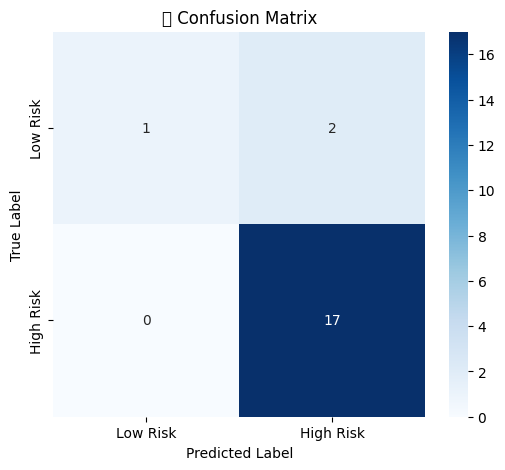


📄 Classification Report:

              precision    recall  f1-score   support

    Low Risk       1.00      0.33      0.50         3
   High Risk       0.89      1.00      0.94        17

    accuracy                           0.90        20
   macro avg       0.95      0.67      0.72        20
weighted avg       0.91      0.90      0.88        20



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


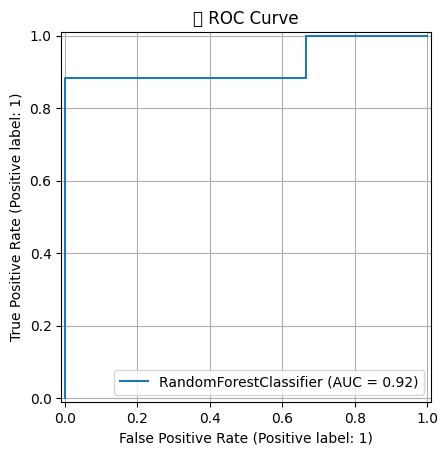

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from google.colab import drive

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay
)

# === Mount Google Drive ===
drive.mount('/content/drive', force_remount=True)

# === Paths ===
base_path = "/content/drive/MyDrive/"
test_data_path = base_path + "test_dataset.csv"
feature_list_path = base_path + "optuna_selected_features.csv"
model_path = base_path + "final_model.pkl"
scaler_path = base_path + "scaler.pkl"

# === Load Data and Model ===
test_df = pd.read_csv(test_data_path)
selected_features = pd.read_csv(feature_list_path)["Feature"].tolist()
model = joblib.load(model_path)
scaler = joblib.load(scaler_path)

# === Extract Features and Labels ===
X = test_df[selected_features]
y = test_df["risk_label"]

# === Scale Features ===
X_scaled = scaler.transform(X)

# === Predict ===
y_pred = model.predict(X_scaled)
y_proba = model.predict_proba(X_scaled)[:, 1]

# === Metrics ===
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred, zero_division=0)
rec = recall_score(y, y_pred, zero_division=0)
f1 = f1_score(y, y_pred, zero_division=0)
roc = roc_auc_score(y, y_proba)

# === Print Metrics ===
print("📊 Classification Metrics:")
print(f" - Accuracy       : {acc:.4f}")
print(f" - Precision      : {prec:.4f}")
print(f" - Recall         : {rec:.4f}")
print(f" - F1 Score       : {f1:.4f}")
print(f" - ROC-AUC Score  : {roc:.4f}")

# === Confusion Matrix ===
labels = ["Low Risk", "High Risk"]
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("🧾 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# === Classification Report ===
print("\n📄 Classification Report:\n")
print(classification_report(y, y_pred, target_names=labels, zero_division=0))

# === ROC Curve ===
RocCurveDisplay.from_estimator(model, X_scaled, y)
plt.title("📈 ROC Curve")
plt.grid(True)
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# === Save All Files to Google Drive ===
import joblib
import pandas as pd

# Save Model
joblib.dump(model, '/content/drive/MyDrive/final_model.pkl')

# Save Scaler
joblib.dump(scaler, '/content/drive/MyDrive/scaler.pkl')

# Save Selected Feature List
pd.DataFrame(selected_features, columns=["Feature"]).to_csv('/content/drive/MyDrive/optuna_selected_features.csv', index=False)

print("✅ All key files saved to Google Drive.")


✅ All key files saved to Google Drive.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# === Load full labeled dataset ===
df = pd.read_csv("/content/drive/MyDrive/labeled_dataset.csv")

# === Split into train and test (80/20) ===
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["risk_label"]
)

# === Save test set to Drive ===
test_df.to_csv("/content/drive/MyDrive/test_dataset.csv", index=False)

print("✅ Test set created and saved as test_dataset.csv")


✅ Test set created and saved as test_dataset.csv
